In [15]:
import pandas as pd
import numpy as np
import sys, os
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# data = pd.read_excel("data/solarsummaries.xlsx")
# data.head()
# xl = pd.ExcelFile("data/solarsummaries.xlsx")
# print(xl.sheet_names) # display a list of the sheets in the spreadsheet

In [44]:
# Define the lat, long of the location and the year
lat, lon, year = 33.2164, -97.1292, 2010
# You must request an NSRDB api key from the link above
api_key = 'laKb0T0Fc9h4lKYiGVSQklvUNfrtWyld83y1k6Ne'
# Set the attributes to extract (e.g., dhi, ghi, etc.), separated by commas.
attributes = 'ghi,dhi,dni,wind_speed_10m_nwp,surface_air_temperature_nwp,solar_zenith_angle'
# Choose year of data
year = '2010'
# Set leap year to true or false. True will return leap day data if present, false will not.
leap_year = 'false'
# Set time interval in minutes, i.e., '30' is half hour intervals. Valid intervals are 30 & 60.
interval = '60'
# Specify Coordinated Universal Time (UTC), 'true' will use UTC, 'false' will use the local time zone of the data.
# NOTE: In order to use the NSRDB data in SAM, you must specify UTC as 'false'. SAM requires the data to be in the
# local time zone.
utc = 'false'
# Your full name, use '+' instead of spaces.
your_name = 'Jack+Sullivan'
# Your reason for using the NSRDB.
reason_for_use = 'beta+testing'
# Your affiliation
your_affiliation = 'UC+Berkeley'
# Your email address
your_email = 'jsullivan27@berkeley.edu'
# Please join our mailing list so we can keep you up-to-date on new developments.
mailing_list = 'false'

# Declare url string
url = 'http://developer.nrel.gov/api/solar/nsrdb_0512_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)

In [45]:
# Return just the first 2 lines to get metadata:
df = pd.read_csv('http://developer.nrel.gov/api/solar/nsrdb_0512_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes), skiprows=2)
# See metadata for specified properties, e.g., timezone and elevation
#timezone, elevation = info['Local Time Zone'], info['Elevation']
df = df.set_index(pd.date_range('1/1/{yr}'.format(yr=year), freq=interval+'Min', periods=525600/int(interval)))

HTTPError: HTTP Error 404: Not Found

In [22]:

df = df.set_index(pd.date_range('1/1/{yr}'.format(yr=year), freq=interval+'Min', periods=44640/int(interval)))
df.head(50)

ValueError: Length mismatch: Expected axis has 17520 elements, new values have 744 elements

In [7]:
df.columns.values

array(['Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DHI', 'DNI',
       'Wind Speed', 'Temperature', 'Solar Zenith Angle'], dtype=object)

In [26]:
# Insert GHI, DHI, and DNI for the last 24 hours and avg over the last week and year.

df["GHI_yesterday"] = df["GHI"].shift(48)

df["GHI_Avg_Week"] = df["GHI"].shift(48)
for i in range(2, 8):
    df["GHI_Avg_Week"] += df["GHI"].shift(48*i)
df["GHI_Avg_Week"] = df["GHI_Avg_Week"] / 7

df["GHI_Avg_Month"] = df["GHI"].shift(48)
for i in range(2, 31):
    df["GHI_Avg_Month"] += df["GHI"].shift(48*i)
df["GHI_Avg_Month"] = df["GHI_Avg_Month"] / 30

In [27]:
df.to_csv('data.csv')

In [42]:
feb = df.loc['2010-03-01 00:00:00':'2010-03-28 00:00:00']

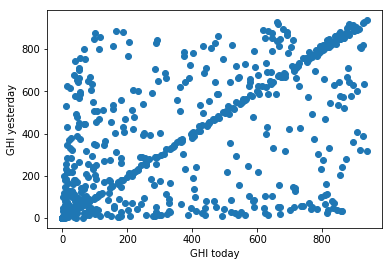

In [43]:
plt.scatter(feb.GHI, feb.GHI_yesterday);
plt.xlabel('GHI today')
plt.ylabel('GHI yesterday');

In [63]:
from sklearn.model_selection import train_test_split
df = df.dropna()
X = df.loc[:, ["GHI_yesterday", "GHI_Avg_Week", "GHI_Avg_Month", "Wind Speed", "Temperature"]]
y = df.loc[:, ["GHI"]]

X, X_test, y, y_test = train_test_split(X, y, test_size = 0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.05, random_state=1)

In [64]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.coef_)

[[ 0.3116104   0.04560161  0.62421221 -1.03457271  0.66516704]]


In [65]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, lm.predict(X_test))

12693.29803954765

In [66]:
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)
print(ridge.coef_)

[[ 0.3116104   0.04560158  0.62421227 -1.0345343   0.66516725]]


In [67]:
mean_squared_error(y_test, ridge.predict(X_test))

12693.298026184171

In [68]:
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)
print(lasso.coef_)

[ 0.31170835  0.04503318  0.62517895 -0.52824829  0.66281501]


In [69]:
mean_squared_error(y_test, lasso.predict(X_test))

12693.65785481305

In [70]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
mses = []

for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_train, y_train)
    mses.append(mean_squared_error(y_test, model.predict(X_test)))

sns.barplot(x=np.array(alphas), y=np.array(mses))

ax = sns.barplot(list(map(str, alphas)), np.array(mses))
ax.set(xlabel='Alphas', ylabel='MSEs', title="MSE vs Alpha")



[Text(0,0.5,'MSEs'), Text(0.5,0,'Alphas'), Text(0.5,1,'MSE vs Alpha')]

In [72]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

rfr_train_score = rfr.score(X_train, y_train)
rfr_val_score = rfr.score(X_val, y_val)

print('Train Score: ', rfr_train_score)
print('Validation Score: ', rfr_val_score)

/Users/jack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Train Score:  0.9790386136253817
Validation Score:  0.8741482859467115


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 101, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(1, 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_dict = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = param_dict, n_iter = 50, cv = 10, random_state=42)
# Fit the random search model
rf_random.fit(X_train, np.array(y_train).reshape(y_train[0]))

print(rf_random.best_params_)

In [ ]:
# With best params found above
rfr_tree = RandomForestRegressor()
rfr_tree.fit(X_train, y_train)

rfr_train_score = rfr_tree.score(X_train, y_train)
rfr_val_score = rfr_tree.score(X_val, y_val)

print('Train Score: ', rfr_train_score)
print('Validation Score: ', rfr_val_score)